# RNA-seq workflow with CAGEscan short reads protocol <br><br>

### Syed Murtuza Baker

## What is CAGE
- __Cap Analysis Gene Expression__
- Produces a snapshot of the 5' end of mRNA
- 5′ cap is a specially altered nucleotide on the 5′ end
- Highly regulated and creates stable mRNA

<center><img src="5_cap_structure.png" height="350" width="350"></center>

## Capturing Single Cells
<br>
<center><img src="mrna-workflow.jpeg" height="800" width="800"></center>

## Overview of CAGE protocol
<br>
<center><img src="CAGE-Protocol.png"></center> <br>

<center><img src="Polymerase_chain_reaction.svg.png"></center>

## PCR duplication artifacts
Some sequences become overrepresented in the final library compared to their true abundance in the fragmented DNA.

## Unique Molecular Identifier (UMI)
- Random sequences of bases used to tag each molecule (fragment)
- Two reads with the same UMI and aligning to the same location:
    - PCR duplicates originating from the same fragment prior to amplification
    - Collapse the reads with the same genomic coordinates and UMI into a single representative read

<center><img src="UMIs.jpg" height="350" width="350">
This figure is adapted from <a href="http://www.nature.com/nmeth/journal/v11/n2/full/nmeth.2772.html#ref8">Islam et al (2014)</a>
</center>


## Differences between UMI & Markduplicates
Markduplicate matches all read pairs that have identical 5' coordinates and orientations

__Problems:__

- Two reads with the same genomic coordinates from two independent fragments

    <font color="green">TATCTCATTATAGGGGGGAGCG</font><br><font color="red">TATCTCATTATAGGGGGGAGCG</font>
- Single-nucleotide polymorphism<br>
    AACAA<font color="red">A</font>TTTAAACAGCTAAA<br>
    AACAA<font color="green">G</font>TTTAAACAGCTAAA
- Highly abundant cDNA sequences are likely to have multiple fragments
- This problem is most acute in single cell RNA-seq

## ERCC Spike-ins
- External RNA Controls Consortium (ERCC) are a common set of external RNA controls
- Total 83 synthetic genes
<center><img src="spikein.png"></center>


For each gene, _i_, calculate the geometric mean

<center>$k^M_i = \left ( \prod\limits_{j=1}^{m}k_{ij} \right )^{ \frac{1}{m}}$</center>
over the counts $k_{ij}$ across all the samples $j=1,\dots,m$ and then use, for each sample the median of the ratio of the sample's counts to these means as a __size factor__: $s_j = median \left ( \frac{k_{ij}}{k^M_i} \right )$

- Calculate size factors for "Technical genes" and "Biological genes"
- "Technical genes" size factor can express cell capture efficiency


## Overview of Data analysis workflow

<center><img src="Workflow_v2.png">

### Tagdust2
TagDust allows users to specify the expected architecture of a read and converts it into a hidden Markov model.
<center><img src="Tagdust_HMM.jpg" height="450" width="450"></center>

### Step 1: Extract UMIs
Tag extraction is done with [TagDust2](http://sourceforge.net/projects/tagdust/files/tagdust-2.13.tar.gz/download). 
During this step, the unique molecular identifiers (UMI) are transferred from the sequence to
the read name, and the spacers are removed

    tagdust -t8 -o ../output/tagdust_r1/C01_S17_R1_001 -1 F:NNNNNNNN -2 S:TATAGGG -3 R:N ../C01_S17_R1_001.fastq.gz

- F: Fingerprint sequence, S: Seperated by, R: Mappable Read

    <font size=4.5>@NB500968:8:H5CFGAFXX:1:11101:4182:1067 1:N:0:AGGCAGAA+ATAGAGAG<br>
    <font color="red">GGGACCGC</font><font color="blue">TATAGGG</font>AATTTAAGACATCATAAAAACAGACAGTTGATGATAACCTGTTGCAGACTTTTTGAGAAG
    <br>__converts to__<br>
    @NB500968:8:H5CFGAFXX:1:11101:4182:1067 1:N:0:AGGCAGAA+ATAGAGAG;<font color="green">FP:43097</font>;RQ:34.67<br>
    AATTTAAGACATCATAAAAACAGACAGTTGATGATAACCTGTTGCAGACTTTTTGAGAAG</font>

### Step 2: Syncing pairs
The reads are then syncronized with `syncpairs` to restore the pairing with the reads.

```bash   
syncpairs ../output/tagdust_r1/C01_S17_R1_001.fq ../output/unzip_r2/C01_S17_R1_001.fq ../output/extracted_r1/C01_S17_R1_001.fq ../output/extracted_r2/C01_S17_R1_001.fq
```

### Step 3: Filtering ribosomal genes and Geting RNA spike-ins
The reads are then filtered against the sequences of ribosomal genes and synthetic RNA spikes using TagDust2 v2.13 in paired-end mode.

```sh
tagdust -arch SimpleArchitecture.txt -dust 20 -ref ../ercc_and_TPA_mouse_rRNA.fa -o ../output/cleaned_reads/C01_S17_R1_001 ../output/extracted_r1/C01_S17_R1_001.fq ../output/extracted_r2/C01_S17_R1_001.fq
```

### Step 4: Align paired-end reads
For each sample separately, the reads are aligned paired-end on the selected genome with `BWA mem` using standard parameters

```bash
bwa mem -M ../bwa/bwa_mm10_random_chrM_chrUn ../output/cleaned_r1/C01_S17_R1_001.fq ../output/cleaned_r2/C01_S17_R1_001.fq > ../output/sampe/C01_S17_R1_001.sam
```

### Step 5: Remove non-properly paired reads
Using samtools, the "genome mapped" reads are filtered by removing non-properly paired reads [4] and non-primary alignments, and then sorted by name. The result is the "properly paired" reads:

    samtools view -f 0x0002 -F 0x0100 -uo - ../output/genome_mapped/C01_S17_R1_001.bam | samtools sort -n - ../output/properly_paired/C01_S17_R1_001
    
The "properly paired" reads are then converted to BED12 format with the program pairedBamToBed12. These are the "CAGEscan pairs":

    pairedBamToBed12 -i ../output/properly_paired/C01_S17_R1_001.bam > ../output/cagescan_pairs/C01_S17_R1_001.bed

### Step 6: Keep unique UMIs
The pairs sharing the same TSS and UMI are then aggregated into "CAGEscan fragments", with the "umicountFP" script of umicount. The CAGEscan fragments represent single transcript molecules:

    umicountFP -f ../output/cagescan_pairs/C01_S17_R1_001.bed > ../output/cagescan_fragments/C01_S17_R1_001.bed

### Step 7: Gene Count
Convert the bed files to bam files and use `featurecount` to count the genes

```bash
bedToBam -i ../output/cagescan_fragments/C01_S17_R1_001.bed -g ../chrom.sizes > ../output/bedToBam_output/C01_S17_R1_001.bam
```
```bash
featureCounts -p -t exon -g gene_id -a /home/baker/my-mm10-index-share/annotation/Gencode-M5/gencode.vM5.annotation.gtf -o <ALL_BAM_FILES>
```

## Problem analysis
- Patched htseq-count and ran it on bam files generated on step 4
- Found that the gene-count with strandness and without strandness varying quite lot
- `PairedBamToBed12` reconstruct the transcripts where he start and end positions are the 5′ end of Read 1 and the 3′ end of Read 2

<center><img src="Read_Alignment.png" height="650" width="650"></center>

### For Trim25 read counts for both stranded and non-stranded were very similar (287 vs 280)

<center><img src="igv_snapshot_StrandnessOK.png"></center>

NB500968:8:H5CFGAFXX:1:11101:21599:9347___1:N:0:CAGAGAGG+ATAGAGAG;FP:39004;RQ:34.69;RQ:-1.00	<font color="green">99</font> chr11

NB500968:8:H5CFGAFXX:1:11101:21599:9347___1:N:0:CAGAGAGG+ATAGAGAG;FP:39004;RQ:34.69;RQ:-1.00	<font color="green">147</font>	chr11

For the FLAG of 99 we transform this into a binary string: 01100011. So accordingly to the flag table:

| Bits | Explanation                                                                |
|------|----------------------------------------------------------------------------|
| 1    | the read is paired in sequencing, no matter whether it is mapped in a pair |
| 1    | the read is mapped in a proper pair                                        |
| 0    | not unmapped                                                               |
| 0    | mate is not unmapped                                                       |
| <font color="green">0</font>    | <font color="green">forward strand</font>                                                             |
| 1    | mate strand is negative                                                    |
| <font color="green">1</font>    | <font color="green">the read is the first read in a pair</font>                                       |
| 0    | the read is not the second read in a pair                                  |

### For Stat5a the Not-stranded count was 273 whereas for Stranded it was 3

### FP:42678
<center><img src="stat5a_snapshot_v2.png"></center>

NB500968:8:H5CFGAFXX:4:21407:11238:19211___1:N:0:CAGAGAGG+ATAGAGAG;FP:42678;RQ:34.57;RQ:-1.00	<font color="red">163</font>	chr11

NB500968:8:H5CFGAFXX:4:21407:11238:19211___1:N:0:CAGAGAGG+ATAGAGAG;FP:42678;RQ:34.57;RQ:-1.00	<font color="red">83</font>	chr11

For the FLAG of 83 we transform this into a binary string: 01010011. So accordingly to the flag table:

| Bits | Explanation                                                                |
|------|----------------------------------------------------------------------------|
| 1    | the read is paired in sequencing, no matter whether it is mapped in a pair |
| 1    | the read is mapped in a proper pair                                        |
| 0    | not unmapped                                                               |
| 0    | mate is not unmapped                                                       |
| <font color="green">1</font>    | <font color="green">negative strand</font>                                                             |
| 0    | mate strand is positive                                                    |
| <font color="green">1</font>    | <font color="green">the read is the first read in a pair</font>                                       |
| 0    | the read is not the second read in a pair                                  |

### Bottlenecks
- Molecular mechanism is not yet clear
- The starting concentration of ERCC-spike ins are confusing
- What to be done with Strandness
- How to deal with optical error

### Pathway and gene set overdispersion analysis (PAGODA)

<center><img src="Heterogeneity_pathway.jpg" width="900" length="1500"><br> Adapted from the paper of Jean Fan et. al.</center>

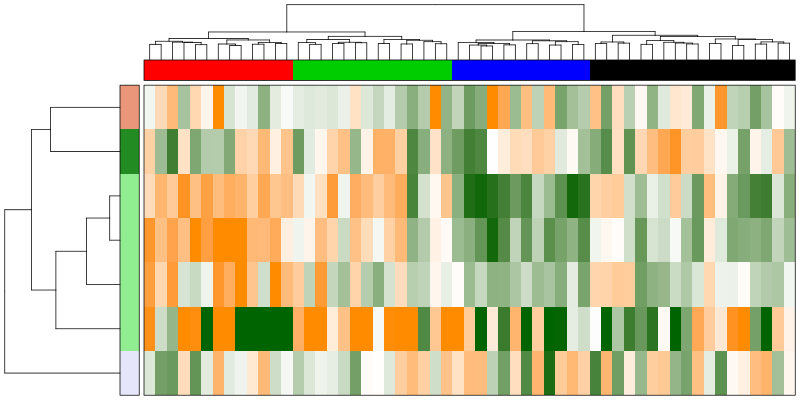

In [257]:
%%R -w 800 -h 400
tamr2 <- pagoda.reduce.redundancy(tamr, distance.threshold = 0.9, plot = TRUE, cell.clustering = hc, labRow = NA, labCol = NA, box = TRUE, margins = c(0.5, 0.5), trim = 0, col.cols = rbind(groups = cutree(hc, 4)))

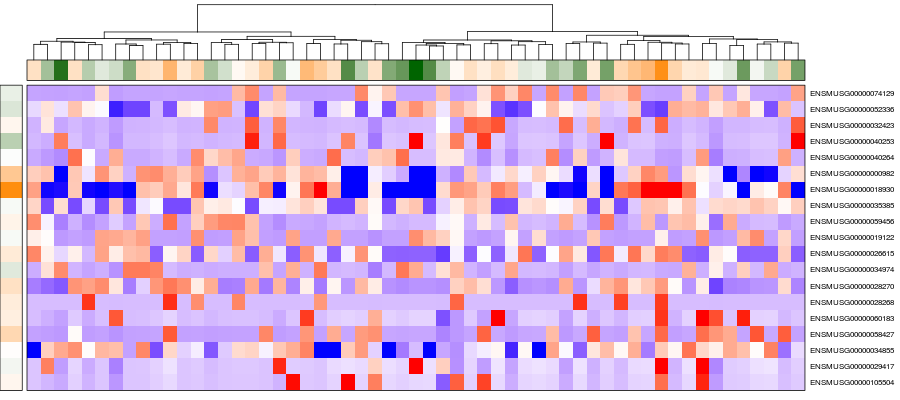

In [343]:
%%R -w 900 -h 400
test<- pagoda.show.pathways(c("GO:0071346 cellular response to interferon-gamma","GO:0070098 chemokine-mediated signaling pathway"), varinfo, go.env, cell.clustering = hc, margins = c(1,10), show.cell.dendrogram = TRUE, showRowLabels = TRUE, showPC = TRUE)

### Prospective works
- Can be used to identify cell cycles
- Can be used to identify branching points

In [146]:
%%R
# compile a browsable app, showing top three clusters with the top color bar
app <- make.pagoda.app(tamr2, tam, varinfo, go.env, pwpca, clpca, col.cols = col.cols, cell.clustering = hc, title = "NPCs")
# show app in the browser (port 1468)
show.app(app, "James_Cluster", browse = TRUE, port = 1468) 

Server started on 127.0.0.1:1468
[1] RookTest      http://127.0.0.1:1468/custom/RookTest
[2] pollen        http://127.0.0.1:1468/custom/pollen
[3] James_Cluster http://127.0.0.1:1468/custom/James_Cluster

Call browse() with an index number or name to run an application.


## Thank you 

## Noise calculation
- Calculate two size factor (i) for 'technical genes' and (ii) 'biological genes'
- For each technical gene $i$, estimate the sample mean $\hat{\mu}$ and sample variance of its normalized counts $\hat{W_i}$
- Similarly we calculate the sample moments for biological gene $i$ as $\hat{\mu}^B$ and $\hat{W_i}^B$
- Simplifying, the expected value of $\hat{W_i}^B$ should be the sum of the technical and biological components of variance
- Fit a GLM model with parameterization $w = \frac{\tilde{a_1}}{\mu} + \alpha_0$
- Similarly we calculate the sample moments for biological gene $i$ as $\hat{\mu}^B$ and $\hat{W_i}^B$
- Technical variance is the value predicted by technical noise fit, $\tilde{a_1}\hat{\mu}^B + \alpha_0 (\hat{\mu}^B)^2$
- For Total variance add $\alpha_i^B (\hat{\mu}^B)^2$ where $\alpha_i^B$ is the squared true coefficient of biological variation


<center><img src="nmeth.2645-F3.jpg" height="450" width="450">

<p style="font-size:20px"> Blue dots correspond to ERCC data points, brown dots to mouse genes, and magenta dots to significantly highly variable mouse genes (at a 10% false discovery rate). The solid red line represents the technical noise fit, and the dashed magenta line marks the expected position of genes with 50% biological CV.</p> 

In [9]:
#import subprocess, os, csv, signal, pysam, collections, optparse, sys, tempfile, re, optparse
#import pandas as pd
#import numpy as np
#import matplotlib.pyplot as plt
#%matplotlib inline

import rpy2.interactive as r
import rpy2.interactive.packages # this can take few seconds
import time
#from ZIFA import ZIFA
#from ZIFA import block_ZIFA
import pylab

ImportError: No module named rpy2.interactive